In [ ]:
#Importing the required libraries:
import os
import sys
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/Hari/Evaluation/LensFinding/")
print("Changed directory to:", os.getcwd())  # Verify the change

Changed directory to: /content/drive/MyDrive/Hari/Evaluation/LensFinding


In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

# Load train dataset
train_data = np.load("/content/drive/MyDrive/Hari/Evaluation/LensFinding/data/train_data.npz")
train_images, train_labels = train_data["images"], train_data["labels"]

# Load validation dataset
val_data = np.load("/content/drive/MyDrive/Hari/Evaluation/LensFinding/data/test_data.npz")
val_images, val_labels = val_data["images"], val_data["labels"]

# Split validation into val + test sets
from sklearn.model_selection import train_test_split
val_images, test_images, val_labels, test_labels = train_test_split(
    val_images, val_labels, test_size=0.20, stratify=val_labels, random_state=42
)

# Identify lens images (Class 1)
lens_indices = np.where(train_labels == 1)[0]
lens_images = train_images[lens_indices]

# Define augmentations
transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=(3,3))
])


# Apply augmentations
num_augmentations =  10 #5 new lense images per original image
augmented_images =  []
for img in lens_images:
    img_tensor = torch.tensor(img).float()
    for _ in range(num_augmentations):
        aug_img = transform(img_tensor).numpy()  # Apply augmentation
        augmented_images.append(aug_img)


# Convert augmented images to NumPy array
augmented_images = np.array(augmented_images)
print(f"Augmented images shape: {augmented_images.shape} and Number of augmented images: {len(augmented_images)}")

# Append augmented images and labels to train set
train_images = np.concatenate([train_images, augmented_images], axis=0)
train_labels = np.concatenate([train_labels, np.ones(len(augmented_images))], axis=0)  # Labels remain 1

# Convert to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

val_images_tensor = torch.tensor(val_images, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# Create DataLoaders
batch_size = 512  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Check a batch
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")
    break


Augmented images shape: (17300, 3, 64, 64) and Number of augmented images: 17300
Batch shape: torch.Size([512, 3, 64, 64]), Labels shape: torch.Size([512])


In [ ]:
print(f"Train set: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Validation set: {val_images.shape}, Labels: {val_labels.shape}")
print(f"Test set: {test_images.shape}, Labels: {test_labels.shape}")

Train set: (47705, 3, 64, 64), Labels: (47705,)
Validation set: (15720, 3, 64, 64), Labels: (15720,)
Test set: (3930, 3, 64, 64), Labels: (3930,)


In [ ]:
sys.path.append("./src")
from model import ResNet26
from train import train_model

In [ ]:
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet26().to(device)
end_time = time.time()
print(f"Model loaded! Time taken: {end_time - start_time:.2f} sec")

Model loaded! Time taken: 0.19 sec


In [ ]:
epochs = 25
learning_rate = 0.0001

In [ ]:
train_losses, val_losses, train_accs, val_accs, val_aucs = train_model(
    model, train_loader, val_loader, device, epochs, learning_rate
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training started!

 Epoch 1/25 started


Epoch 1 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 1 Training: 100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


[Epoch 1/25] Train Loss: 0.514873 | Train Acc: 0.680 | Val Loss: 1.959281 | Val Acc: 0.114 | Val AUC: 0.7958
Saved new best model with Val AUC: 0.7958
Saved new best model with Val ACC: 0.1141

 Epoch 2/25 started


Epoch 2 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 2 Training: 100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


[Epoch 2/25] Train Loss: 0.236518 | Train Acc: 0.643 | Val Loss: 2.332381 | Val Acc: 0.066 | Val AUC: 0.7966
Saved new best model with Val AUC: 0.7966

 Epoch 3/25 started


Epoch 3 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 3 Training: 100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


[Epoch 3/25] Train Loss: 0.201865 | Train Acc: 0.609 | Val Loss: 1.931697 | Val Acc: 0.176 | Val AUC: 0.8044
Saved new best model with Val AUC: 0.8044
Saved new best model with Val ACC: 0.1756

 Epoch 4/25 started


Epoch 4 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 4 Training: 100%|██████████| 94/94 [00:24<00:00,  3.80it/s]


[Epoch 4/25] Train Loss: 0.182416 | Train Acc: 0.623 | Val Loss: 1.741671 | Val Acc: 0.452 | Val AUC: 0.8654
Saved new best model with Val AUC: 0.8654
Saved new best model with Val ACC: 0.4518

 Epoch 5/25 started


Epoch 5 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 5 Training: 100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


[Epoch 5/25] Train Loss: 0.170448 | Train Acc: 0.654 | Val Loss: 1.728143 | Val Acc: 0.498 | Val AUC: 0.8763
Saved new best model with Val AUC: 0.8763
Saved new best model with Val ACC: 0.4983

 Epoch 6/25 started


Epoch 6 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 6 Training: 100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


[Epoch 6/25] Train Loss: 0.165777 | Train Acc: 0.670 | Val Loss: 1.771540 | Val Acc: 0.544 | Val AUC: 0.8716
Saved new best model with Val ACC: 0.5441

 Epoch 7/25 started


Epoch 7 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 7 Training: 100%|██████████| 94/94 [00:25<00:00,  3.69it/s]


[Epoch 7/25] Train Loss: 0.163283 | Train Acc: 0.684 | Val Loss: 1.595597 | Val Acc: 0.517 | Val AUC: 0.9024
Saved new best model with Val AUC: 0.9024

 Epoch 8/25 started


Epoch 8 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 8 Training: 100%|██████████| 94/94 [00:25<00:00,  3.73it/s]


[Epoch 8/25] Train Loss: 0.159812 | Train Acc: 0.694 | Val Loss: 1.627976 | Val Acc: 0.519 | Val AUC: 0.8989

 Epoch 9/25 started


Epoch 9 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 9 Training: 100%|██████████| 94/94 [00:25<00:00,  3.73it/s]


[Epoch 9/25] Train Loss: 0.158103 | Train Acc: 0.699 | Val Loss: 1.523127 | Val Acc: 0.587 | Val AUC: 0.9058
Saved new best model with Val AUC: 0.9058
Saved new best model with Val ACC: 0.5873

 Epoch 10/25 started


Epoch 10 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 10 Training: 100%|██████████| 94/94 [00:25<00:00,  3.71it/s]


[Epoch 10/25] Train Loss: 0.155979 | Train Acc: 0.704 | Val Loss: 1.448241 | Val Acc: 0.539 | Val AUC: 0.9296
Saved new best model with Val AUC: 0.9296

 Epoch 11/25 started


Epoch 11 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 11 Training: 100%|██████████| 94/94 [00:25<00:00,  3.72it/s]


[Epoch 11/25] Train Loss: 0.154226 | Train Acc: 0.711 | Val Loss: 1.383170 | Val Acc: 0.578 | Val AUC: 0.9348
Saved new best model with Val AUC: 0.9348

 Epoch 12/25 started


Epoch 12 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 12 Training: 100%|██████████| 94/94 [00:25<00:00,  3.70it/s]


[Epoch 12/25] Train Loss: 0.151985 | Train Acc: 0.719 | Val Loss: 1.309107 | Val Acc: 0.609 | Val AUC: 0.9445
Saved new best model with Val AUC: 0.9445
Saved new best model with Val ACC: 0.6090

 Epoch 13/25 started


Epoch 13 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 13 Training: 100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


[Epoch 13/25] Train Loss: 0.150861 | Train Acc: 0.723 | Val Loss: 1.336170 | Val Acc: 0.668 | Val AUC: 0.9359
Saved new best model with Val ACC: 0.6677

 Epoch 14/25 started


Epoch 14 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 14 Training: 100%|██████████| 94/94 [00:25<00:00,  3.69it/s]


[Epoch 14/25] Train Loss: 0.149278 | Train Acc: 0.727 | Val Loss: 1.374060 | Val Acc: 0.568 | Val AUC: 0.9470
Saved new best model with Val AUC: 0.9470

 Epoch 15/25 started


Epoch 15 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 15 Training: 100%|██████████| 94/94 [00:25<00:00,  3.70it/s]


[Epoch 15/25] Train Loss: 0.148490 | Train Acc: 0.735 | Val Loss: 1.383220 | Val Acc: 0.640 | Val AUC: 0.9444

 Epoch 16/25 started


Epoch 16 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 16 Training: 100%|██████████| 94/94 [00:25<00:00,  3.72it/s]


[Epoch 16/25] Train Loss: 0.146733 | Train Acc: 0.731 | Val Loss: 1.336383 | Val Acc: 0.643 | Val AUC: 0.9503
Saved new best model with Val AUC: 0.9503

 Epoch 17/25 started


Epoch 17 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 17 Training: 100%|██████████| 94/94 [00:25<00:00,  3.72it/s]


[Epoch 17/25] Train Loss: 0.146241 | Train Acc: 0.748 | Val Loss: 1.339244 | Val Acc: 0.631 | Val AUC: 0.9534
Saved new best model with Val AUC: 0.9534

 Epoch 18/25 started


Epoch 18 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 18 Training: 100%|██████████| 94/94 [00:25<00:00,  3.70it/s]


[Epoch 18/25] Train Loss: 0.146298 | Train Acc: 0.744 | Val Loss: 1.320847 | Val Acc: 0.659 | Val AUC: 0.9533

 Epoch 19/25 started


Epoch 19 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 19 Training: 100%|██████████| 94/94 [00:25<00:00,  3.72it/s]


[Epoch 19/25] Train Loss: 0.145878 | Train Acc: 0.747 | Val Loss: 1.333029 | Val Acc: 0.650 | Val AUC: 0.9538
Saved new best model with Val AUC: 0.9538

 Epoch 20/25 started


Epoch 20 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 20 Training: 100%|██████████| 94/94 [00:25<00:00,  3.72it/s]


[Epoch 20/25] Train Loss: 0.146142 | Train Acc: 0.745 | Val Loss: 1.334388 | Val Acc: 0.658 | Val AUC: 0.9540
Saved new best model with Val AUC: 0.9540

 Epoch 21/25 started


Epoch 21 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 21 Training: 100%|██████████| 94/94 [00:25<00:00,  3.69it/s]


[Epoch 21/25] Train Loss: 0.146505 | Train Acc: 0.743 | Val Loss: 1.310912 | Val Acc: 0.667 | Val AUC: 0.9540
Saved new best model with Val AUC: 0.9540

 Epoch 22/25 started


Epoch 22 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 22 Training: 100%|██████████| 94/94 [00:25<00:00,  3.72it/s]


[Epoch 22/25] Train Loss: 0.145769 | Train Acc: 0.743 | Val Loss: 1.297024 | Val Acc: 0.680 | Val AUC: 0.9567
Saved new best model with Val AUC: 0.9567
Saved new best model with Val ACC: 0.6802

 Epoch 23/25 started


Epoch 23 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 23 Training: 100%|██████████| 94/94 [00:25<00:00,  3.70it/s]


[Epoch 23/25] Train Loss: 0.146327 | Train Acc: 0.742 | Val Loss: 1.348164 | Val Acc: 0.648 | Val AUC: 0.9529

 Epoch 24/25 started


Epoch 24 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 24 Training: 100%|██████████| 94/94 [00:25<00:00,  3.73it/s]


[Epoch 24/25] Train Loss: 0.146083 | Train Acc: 0.741 | Val Loss: 1.325785 | Val Acc: 0.660 | Val AUC: 0.9529

 Epoch 25/25 started


Epoch 25 Training:   0%|          | 0/94 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 25 Training: 100%|██████████| 94/94 [00:25<00:00,  3.72it/s]


[Epoch 25/25] Train Loss: 0.146133 | Train Acc: 0.744 | Val Loss: 1.320730 | Val Acc: 0.650 | Val AUC: 0.9536


In [ ]:
print("Train_Losses : \n",train_losses)
print("Val_Losses :  \n",val_losses)
print("Train_Accs :  \n",train_accs)
print("Val_Accs :  \n",val_accs)
print("Val_AUCs : \n",val_aucs)

Train_Losses : 
 [0.5148728785887415, 0.23651849392224827, 0.2018653780887267, 0.18241597742182744, 0.17044813514549195, 0.16577698896233858, 0.16328316600414433, 0.15981188059952658, 0.15810322754226408, 0.1559786676510914, 0.15422645995463483, 0.15198453451749752, 0.1508611960307868, 0.14927766173203377, 0.14848991457539626, 0.1467332305126427, 0.1462407810075667, 0.14629755253568658, 0.14587765026612298, 0.14614179261437177, 0.1465054970075719, 0.14576930974423416, 0.14632725757118692, 0.14608311212396438, 0.14613324807894928]
Val_Losses :  
 [1.9592810417252946, 2.3323805039772245, 1.931696596339762, 1.7416713058190187, 1.728142580245894, 1.7715401730767946, 1.5955974793616141, 1.6279764836071102, 1.5231271603028587, 1.4482411332409497, 1.3831695455934558, 1.3091073263692492, 1.336170474445547, 1.3740603058089433, 1.3832202973256584, 1.3363825749501623, 1.339244411677198, 1.3208470634528395, 1.3330290651200078, 1.3343879869572686, 1.310911903915211, 1.2970240647556217, 1.3481635207

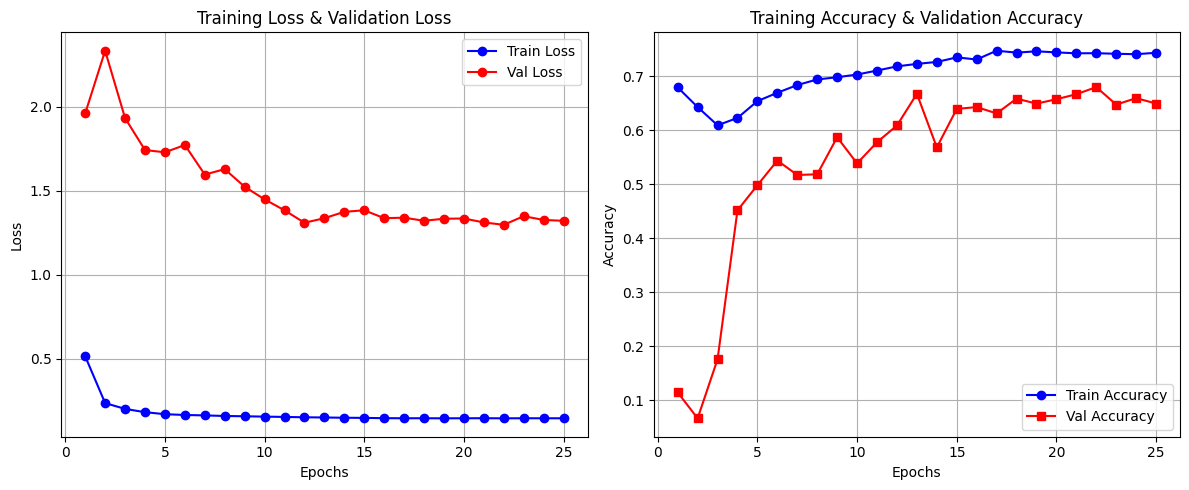

In [ ]:
epochs_ = range(1,len(train_losses)+1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_, train_losses, label="Train Loss", marker="o", color="blue")
plt.plot(epochs_, val_losses, label="Val Loss", marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss & Validation Loss")
plt.legend()
plt.grid(True)

# Plot Validation Loss & Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_, train_accs, label="Train Accuracy", marker="o", color="blue")
plt.plot(epochs_, val_accs, label="Val Accuracy", marker="s", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy & Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Hari/Evaluation/LensFinding/results/best_model_auc.pth"))

<All keys matched successfully>

In [ ]:
def evaluate(model, dataloader, device):
    """ Runs inference on the entire test dataset and computes accuracy & loss. """
    model.eval()  # Set model to evaluation mode
    total_loss, correct = 0, 0
    total_samples = 0

    with torch.no_grad():  # No gradients needed during inference
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)

            # Compute predictions
            preds = outputs.argmax(dim=1)  # Get class with highest probability
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item() * images.size(0)

    # Compute final metrics
    avg_loss = total_loss / total_samples
    accuracy = correct / total_samples
    return avg_loss, accuracy

test_loss, test_acc = evaluate(model, test_loader, device)
print(test_acc)

0.6712468193384223


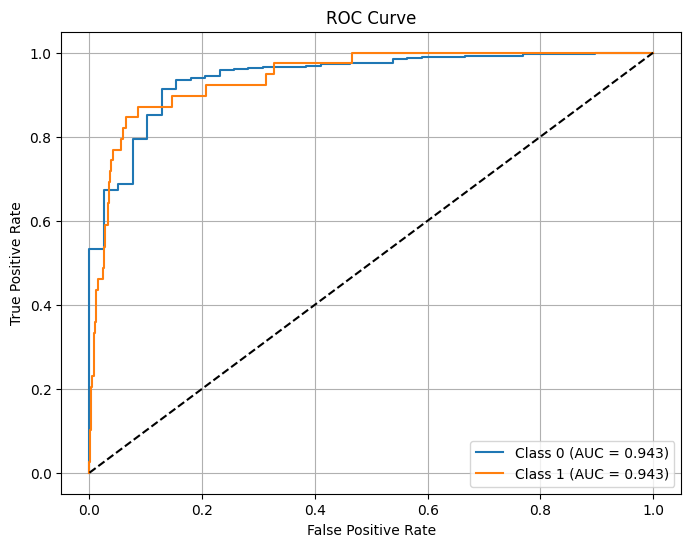

In [ ]:
#ROC and AUC analysis using sklearn :
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from sklearn.metrics import roc_auc_score

def compute_roc_auc(model, dataloader, device, num_classes=2):
    """Computes ROC curves and AUC scores for each class."""
    model.eval()

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.cpu().numpy()  # Convert labels to NumPy
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Get probabilities

            all_labels.extend(labels)
            all_probs.extend(probs)

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    # Binarize labels for multi-class ROC
    all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))

    # Compute ROC curve and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        #class_probs = all_probs[:, i]
        fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])  # Binary classification for each class
        roc_auc[i] = auc(fpr[i], tpr[i])

    return fpr, tpr, roc_auc

def plot_roc_curves(fpr, tpr, roc_auc, num_classes=2):
    """Plots ROC curves for each class."""
    plt.figure(figsize=(8, 6))

    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.3f})")

    plt.plot([0, 1], [0, 1], "k--")  # Diagonal line (random classifier)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

#Compute ROC & AUC
fpr, tpr, roc_auc = compute_roc_auc(model, test_loader, device)

# Plot ROC Curves
plot_roc_curves(fpr, tpr, roc_auc)

Before this Training Attempt  :

Similar AUC Scores indicate that the model is classifying both the labels neraly in the same way.
But the test accuracy is still low at 71 %, even after data augmentation to make new lense images.For now I will increase the number of Augmented lense images and try to fix the wildly oscillating val loss and accuracy and see the results.

After this Training Attempt :

Oscillations of val loss and acc have significantly reduced but both are still significantly lagging as compared to train loss and acc, also we notice that train loss and acc have changed towards the bad side as compared to the previous round, this is because we made the model more shallower and added more dropout to counter overfitting.

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Hari/Evaluation/LensFinding/results/best_model_acc.pth"))

<All keys matched successfully>

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, device)
print(test_acc)

0.6712468193384223


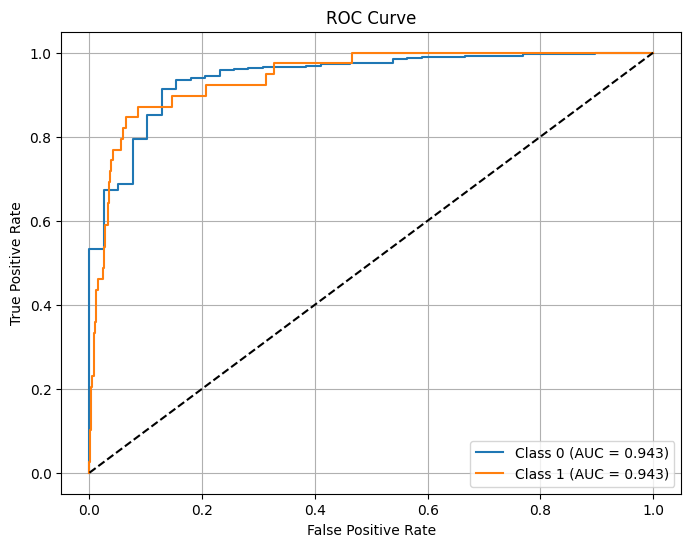

In [ ]:
#Compute ROC & AUC
fpr, tpr, roc_auc = compute_roc_auc(model, test_loader, device)

# Plot ROC Curves
plot_roc_curves(fpr, tpr, roc_auc)

I will stop the training process here and the model weights for each training attempt are store in the results folder. Nearly all training attempts had some or the other shortcomings. A much better way to approach the data imablance can be to use Deep Generative models to make new images of the underrepresented class and then train the model on them. Limited Compute(GPU) resources stopped me from implementing the same.


The required Evaulation/Inference Metrics were implemented on the test dataset in each training attempt and the same can be noticed in all notebooks.


For an evaluation I recommend using the model weights stored under the name and location : "./results/training_3.pth" (best Accuracy) or the ones stored as "./results/train_1_re.pth"(best AUC scores for both classes).